Importing required packages and checks if py3Dmol is installed.

In [1]:
import os
from Bio.PDB import PDBParser, NeighborSearch, Selection
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import copy

try:
    import py3Dmol
    py3Dmol_installed = True
except ImportError:
    py3Dmol_installed = False

print("Packages are loaded and Py3Dmol installed:", py3Dmol_installed)


Packages are loaded and Py3Dmol installed: True


Assigning and parsing the PDB file, and printing structure ID and number of chains.

In [2]:
#Assigning PDB ID and Directing to file path.
pdb_id = "1YCR"
pdb_file = f"data/{pdb_id}.pdb"

#Parsing the structure 
parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, pdb_file)

#Description
print(f"Structure ID: {structure.id}")
for model in structure:
    print(f"Number of chains: {len(model)}")

Structure ID: 1YCR
Number of chains: 2


Loading chains A and B, defining a function to find interface residues, and printing interface residues for both chains.

In [3]:
model = structure[0]
chainA = model ['A']
chainB = model ['B']

print("Chain loaded for PPI:", chainA.id, "and", chainB.id)

#Defining a function to get interface residues
def get_interface_residues(chain1, chain2, cutoff=5.0):
    atoms1= Selection.unfold_entities(chain1, 'A')
    atoms2= Selection.unfold_entities(chain2, 'A')
    ns = NeighborSearch(list(atoms2))

    interface_residues = set()
    for atom in atoms1:
        neighbors = ns.search(atom.coord, cutoff)
        if neighbors:
            interface_residues.add(atom.get_parent().id[1])
    return interface_residues

#Getting interface residues for both chains (A and B)
interface_A = get_interface_residues(chainA, chainB)
interface_B = get_interface_residues(chainB, chainA)

#printing interface residues
print(f"Chain A interface residues: {sorted(interface_A)}")
print(f"Chain B interface residues: {sorted(interface_B)}")



Chain loaded for PPI: A and B
Chain A interface residues: [25, 26, 50, 51, 54, 55, 57, 58, 61, 62, 67, 70, 71, 72, 73, 75, 91, 93, 94, 96, 99, 100, 103, 104]
Chain B interface residues: [17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29]


Building the protein–protein interaction graph by adding interface residues as nodes and connecting them with edges based on spatial proximity.

In [4]:
G= nx.Graph()

for res_id in interface_A:
    G.add_node(('A', res_id), chain='A')

for res_id in interface_B:
    G.add_node(('B', res_id), chain='B')

print(f"Nodes added: {G.number_of_nodes()}")

atomsA = [atom for res in chainA if res.id[1] in interface_A for atom in res]
atomsB = [atom for res in chainB if res.id[1] in interface_B for atom in res]

nsB = NeighborSearch(list(atomsB))
cutoff = 5.0

for atomA in atomsA:
    close_atoms = nsB.search(atomA.coord, cutoff)
    for atomB in close_atoms:
        resA = atomA.get_parent()
        resB = atomB.get_parent()
        G.add_edge(
            ('A', resA.id[1]),
            ('B', resB.id[1]),
            weight=np.linalg.norm(atomA.coord - atomB.coord)
        )

print(f"PPI Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Nodes added: 35
PPI Graph created with 35 nodes and 48 edges.


Calculating node degree and betweenness centrality, then printing the top 10 interface residues ranked by each metric.

In [5]:
# Degree
degree_dict = dict(G.degree())

# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)

# Top residues by degree (hubs)
top_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 interface residues by degree:", top_degree)

# Top residues by betweenness (bottlenecks)
top_betweenness = sorted(betweenness_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 interface residues by betweenness:", top_betweenness)


Top 10 interface residues by degree: [(('B', 23), 10), (('B', 19), 7), (('B', 29), 6), (('B', 17), 5), (('B', 22), 5), (('A', 54), 4), (('A', 72), 4), (('A', 93), 4), (('A', 96), 4), (('B', 26), 4)]
Top 10 interface residues by betweenness: [(('B', 23), 0.411484789183193), (('A', 54), 0.27534721234910986), (('B', 22), 0.24673082846428088), (('B', 19), 0.23256459675144792), (('B', 27), 0.20912535249514821), (('A', 96), 0.2013267160549223), (('A', 72), 0.1773021381515633), (('A', 93), 0.17069558764502396), (('B', 28), 0.14756009329064354), (('B', 29), 0.13541099423452366)]


Visualizing the PPI network with spring layout, highlighting top-degree residues in orange and top-betweenness residues in red.

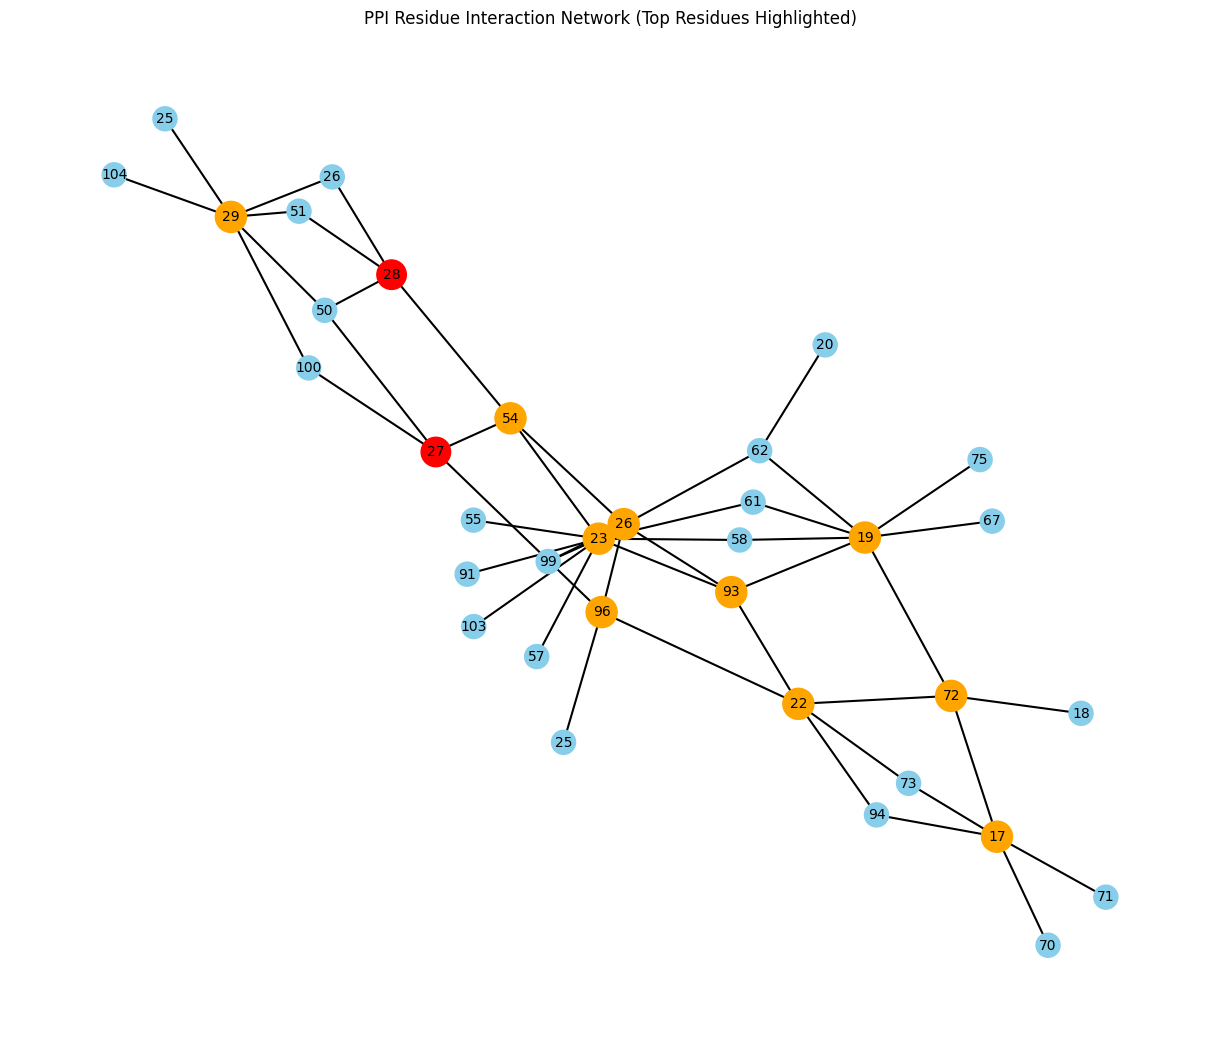

In [6]:
# Extracting top nodes for coloring
top_degree_nodes = [node for node, _ in top_degree]
top_betweenness_nodes = [node for node, _ in top_betweenness]

# Assigning colors and sizes
node_colors = []
node_sizes = []

for node in G.nodes():
    if node in top_degree_nodes:
        node_colors.append('orange')   # hubs
        node_sizes.append(500)
    elif node in top_betweenness_nodes:
        node_colors.append('red')      # bottlenecks
        node_sizes.append(450)
    else:
        node_colors.append('skyblue')  # other residues
        node_sizes.append(300)

# Layout for plotting
plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    labels={node: node[1] for node in G.nodes()},
    node_color=node_colors,
    node_size=node_sizes,
    font_size=10,
    width=1.5
)

plt.title("PPI Residue Interaction Network (Top Residues Highlighted)")
plt.axis('off')
plt.show()


Displaying the 3D protein structure with py3Dmol, highlighting top-degree residues in orange and top-betweenness residues in red.

In [7]:
if py3Dmol_installed:
    view = py3Dmol.view(query=f'pdb:{pdb_id}')
    view.setStyle({'cartoon': {'color':'lightgrey'}})

    # Highlighting top-degree residues in orange
    for node in top_degree_nodes:
        chain, res_id = node
        view.addStyle({'chain': chain, 'resi': res_id}, {'stick': {'color':'orange'}})

    # Highlighting top-betweenness residues in red
    for node in top_betweenness_nodes:
        chain, res_id = node
        view.addStyle({'chain': chain, 'resi': res_id}, {'stick': {'color':'red'}})

    view.zoomTo()
    view.show()
else:
    print("Py3Dmol not installed, skipping 3D visualization.")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
# Copy original network
G_mut = G.copy()

# Simulate mutation: remove residue 23 in chain B
mutated_residue = ('B', 23)
if mutated_residue in G_mut:
    G_mut.remove_node(mutated_residue)

# Recompute network metrics
degree_mut = dict(G_mut.degree())
betweenness_mut = nx.betweenness_centrality(G_mut)

print("After mutation (B23 -> ALA):")
print("Top degree residues:", sorted(degree_mut.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top betweenness residues:", sorted(betweenness_mut.items(), key=lambda x: x[1], reverse=True)[:5])


After mutation (B23 -> ALA):
Top degree residues: [(('B', 19), 7), (('B', 29), 6), (('B', 17), 5), (('B', 22), 5), (('A', 72), 4)]
Top betweenness residues: [(('B', 19), 0.2997319383832542), (('B', 22), 0.2650149624431921), (('A', 96), 0.26425726220881723), (('B', 27), 0.2152988043986848), (('B', 26), 0.21392771403237912)]


Collecting node and edge metrics into dataframes and saves them as CSV files for downstream analysis.

In [ ]:
nodes_data = []

for node in G.nodes():
    nodes_data.append({
        'Chain': node[0],
        'Residue': node[1],
        'Degree': degree_dict.get(node, 0),
        'Betweenness': betweenness_dict.get(node, 0),
        'Role': 'Hub' if node in top_degree_nodes else ('Bottleneck' if node in top_betweenness_nodes else 'Normal')
    })

df_nodes = pd.DataFrame(nodes_data)
df_nodes.to_csv(f'{pdb_id}_PPI_nodes.csv', index=False)
print(f"Node metrics saved to {pdb_id}_PPI_nodes.csv")

#Saving Nodes and Edges
edges_data = []

for u, v, data in G.edges(data=True):
    edges_data.append({
        'Residue1': f"{u[0]}{u[1]}",
        'Residue2': f"{v[0]}{v[1]}",
        'Distance': data['weight']
    })

df_edges = pd.DataFrame(edges_data)
df_edges.to_csv(f'{pdb_id}_PPI_edges.csv', index=False)
print(f"Edge list saved to {pdb_id}_PPI_edges.csv")

Node metrics saved to 1YCR_PPI_nodes.csv
Edge list saved to 1YCR_PPI_edges.csv
